# Synthetic seismic: wedge

## Make an earth model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [2]:
length = 80  # x range
depth = 200  # z range

In [3]:
# We have to pass dtype=int or we get floats.
# We need ints because we're going to use for indexing later.
model = 1 + np.tri(depth, length, -depth//3, dtype=int)

Now set the upper part of the model — above the wedge — to zero.

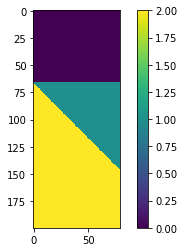

In [4]:
model[:depth//3,:] = 0

plt.imshow(model)
plt.colorbar()
plt.show()

Now we can make some Vp-rho pairs (rock 0 and rock 1).

In [5]:
rocks = np.array([[2700, 2750],
                  [2400, 2450],
                  [2800, 3000]])

Now we can use ['fancy indexing'](http://docs.scipy.org/doc/numpy/user/basics.indexing.html) to use `model`, which is an array of 0, 1, and 2, as the indices of the rock property pairs to 'grab' from `rocks`.

In [6]:
earth = rocks[model]

Now apply `np.product` to those Vp-rho pairs to get impedance at every sample.

In [7]:
imp = np.apply_along_axis(np.product, -1, earth)

## Model seismic reflections

Now we have an earth model — giving us acoustic impedance everywhere in this 2D grid — we define a function to compute reflection coefficients for every trace.

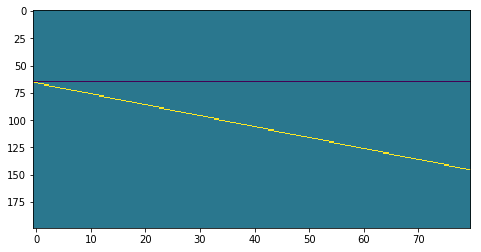

In [8]:
def make_rc(imp):
    upper = imp[ :-1, :]
    lower = imp[1:  , :]
    
    return (lower - upper) / (lower + upper)

rc = make_rc(imp)

plt.figure(figsize=(8,4))
plt.imshow(rc, aspect=0.2)
plt.show()

We'll use `bruges` to make a wavelet:

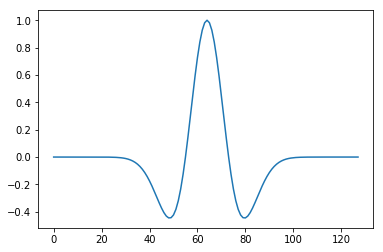

In [9]:
from bruges.filters import ricker

f = 25  # Hz
wavelet = ricker(0.128, 0.001, f)

plt.plot(wavelet)
plt.show()

It's only a little trickier for us to apply 1D convolution to every trace in our 2D reflection coeeficient matrix. NumPy provides a function, `apply_along_axis()` to apply any function along any one axis of an n-dimensional array. I don't think it's much faster than looping, but I find it easier to think about.

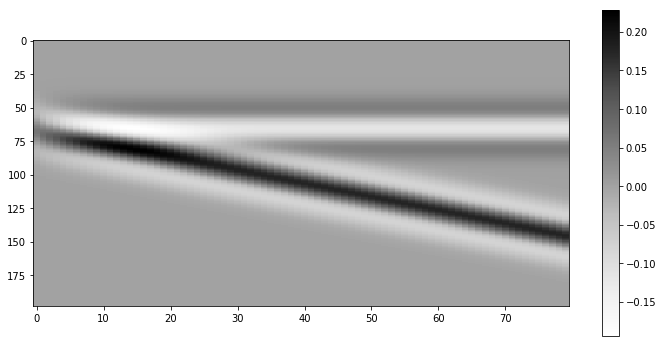

In [10]:
def convolve(trace):
    return np.convolve(trace, wavelet, mode='same')

synth = np.apply_along_axis(convolve,
                            axis=0,
                            arr=rc)

plt.figure(figsize=(12,6))
plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.colorbar()
plt.show()

## A really cool model

Let's load an image and use it as a model.

In [11]:
import matplotlib.image as mpimg

img = mpimg.imread('data/Hubbard_etal_2014.png')

This is just a 4-channel PNG (red, green, blue, alpha).

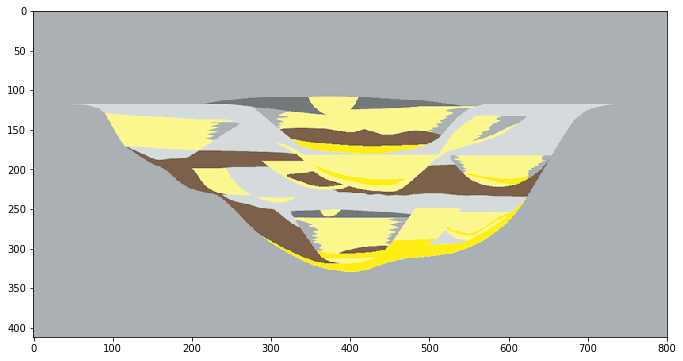

In [12]:
plt.figure(figsize=(12,6))
plt.imshow(img)

Let's pretend we can make impedance by averaging the channels (there are lots of equally geologically silly ways to do this).

In [13]:
imp = np.apply_along_axis(np.mean, -1, img)

Now carry on as before.

In [14]:
rc = make_rc(imp)

synth = np.apply_along_axis(convolve,
                            axis=0,
                            arr=rc)

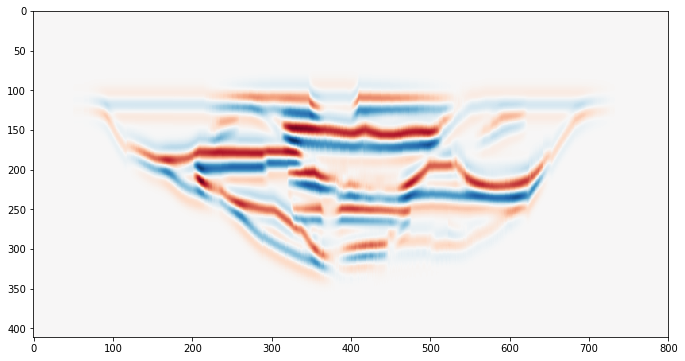

In [15]:
plt.figure(figsize=(12,6))
plt.imshow(synth, cmap="RdBu")
plt.show()

## One more thing

We can make this plot interactive, but first we have to turn it into a function.

Then it's as simple as doing `from ipywidgets import interact` and adding the `interact` decorator to the function, with a sensible range for the frequency, e.g. `@interact(f=(10,50))`.

This provides a JavaScript slider and a path to update the plot interactively with new values of one or more frequencies.

In [16]:
def make_synthetic(f):
    wavelet = ricker(0.128, 0.001, f)
    def convolve(trace):
        return np.convolve(trace, wavelet, mode='same')

    synth = np.apply_along_axis(convolve,
                                axis=0,
                                arr=rc)
    plt.figure(figsize=(12,6))
    plt.imshow(synth, cmap="RdBu")
    plt.show()
    return

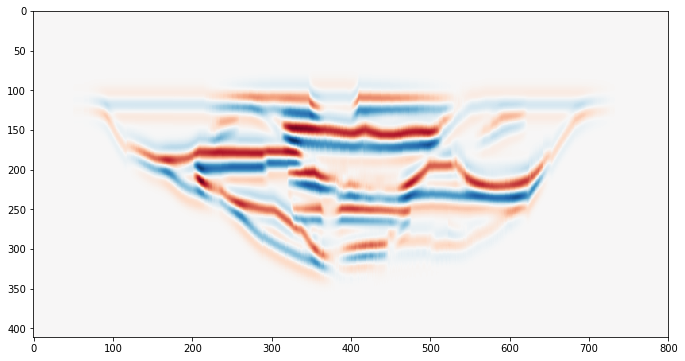

In [17]:
make_synthetic(25)

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>